Sample vocab: ['', '[UNK]', np.str_('yang'), np.str_('di'), np.str_('dan'), np.str_('tidak'), np.str_('saya'), np.str_('dengan'), np.str_('enak'), np.str_('ini')]
Max index: 2836

=== Running bidir: {'n_layers': 3, 'units': [64, 128, 256], 'bidirectional': True}
Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - loss: 1.0486 - val_loss: 1.0145
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - loss: 0.8537 - val_loss: 0.8182
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - loss: 0.5560 - val_loss: 0.9192
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - loss: 0.3558 - val_loss: 1.1204
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - loss: 0.2509 - val_loss: 1.1578
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
bidir macro-F1: 0.6050


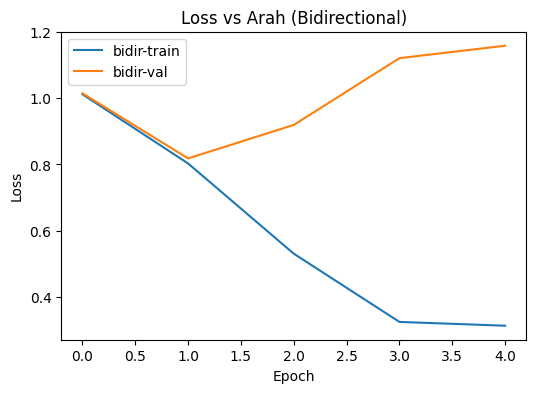

/Users/enrique/Projects/Coding/ML-2-8/src/models/lstm/lstm_layer.py:18: RuntimeWarning: divide by zero encountered in matmul
  z = xt @ self.W + H @ self.U + self.b
/Users/enrique/Projects/Coding/ML-2-8/src/models/lstm/lstm_layer.py:18: RuntimeWarning: overflow encountered in matmul
  z = xt @ self.W + H @ self.U + self.b
/Users/enrique/Projects/Coding/ML-2-8/src/models/lstm/lstm_layer.py:18: RuntimeWarning: invalid value encountered in matmul
  z = xt @ self.W + H @ self.U + self.b


 3/13 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

/Users/enrique/Projects/Coding/ML-2-8/src/models/lstm/dense_layer.py:10: RuntimeWarning: divide by zero encountered in matmul
  z = x @ self.W + self.b
/Users/enrique/Projects/Coding/ML-2-8/src/models/lstm/dense_layer.py:10: RuntimeWarning: overflow encountered in matmul
  z = x @ self.W + self.b
/Users/enrique/Projects/Coding/ML-2-8/src/models/lstm/dense_layer.py:10: RuntimeWarning: invalid value encountered in matmul
  z = x @ self.W + self.b


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
max|keras - scratch| = 1.847744e-06
macro-F1 (scratch): 0.6050


/Users/enrique/Projects/Coding/ML-2-8/src/models/lstm/lstm_layer.py:18: RuntimeWarning: divide by zero encountered in matmul
  z = xt @ self.W + H @ self.U + self.b
/Users/enrique/Projects/Coding/ML-2-8/src/models/lstm/lstm_layer.py:18: RuntimeWarning: overflow encountered in matmul
  z = xt @ self.W + H @ self.U + self.b
/Users/enrique/Projects/Coding/ML-2-8/src/models/lstm/lstm_layer.py:18: RuntimeWarning: invalid value encountered in matmul
  z = xt @ self.W + H @ self.U + self.b


max|scratch - loaded| = 0.0
macro-F1 (scratch loaded): 0.6050


/Users/enrique/Projects/Coding/ML-2-8/src/models/lstm/dense_layer.py:10: RuntimeWarning: divide by zero encountered in matmul
  z = x @ self.W + self.b
/Users/enrique/Projects/Coding/ML-2-8/src/models/lstm/dense_layer.py:10: RuntimeWarning: overflow encountered in matmul
  z = x @ self.W + self.b
/Users/enrique/Projects/Coding/ML-2-8/src/models/lstm/dense_layer.py:10: RuntimeWarning: invalid value encountered in matmul
  z = x @ self.W + self.b


In [13]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import torch as tc
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score

from models.lstm.keras_model import build_lstm_model
from models.lstm.scratch_model import ScratchLSTMClassifier
from tensorflow.keras.layers import TextVectorization

# Set seed
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)  
tc.manual_seed(SEED)
tc.backends.cudnn.deterministic = True
tc.backends.cudnn.benchmark = False
tc.use_deterministic_algorithms(True)
tf.config.experimental.enable_op_determinism()


train = pd.read_csv('./../data/nusaX-sentiment/train.csv')
valid = pd.read_csv('./../data/nusaX-sentiment/valid.csv')
test  = pd.read_csv('./../data/nusaX-sentiment/test.csv')

le = LabelEncoder()
y_train = le.fit_transform(train['label'])
y_val   = le.transform(valid['label'])
y_test  = le.transform(test['label'])
num_classes = len(le.classes_)

texts_train = train['text'].astype(str).tolist()
texts_val   = valid['text'].astype(str).tolist()
texts_test  = test['text'].astype(str).tolist()

max_tokens = 20000
max_len    = 100
embed_dim  = 128

vectorizer = TextVectorization(max_tokens=max_tokens, output_sequence_length=max_len)
vectorizer.adapt(texts_train)

def make_dataset(texts, labels, batch=32, shuffle=True):
    x = vectorizer(tf.constant(texts))
    ds = tf.data.Dataset.from_tensor_slices((x, labels))
    if shuffle: ds = ds.shuffle(1024)
    return ds.batch(batch).prefetch(1)

print("Sample vocab:", vectorizer.get_vocabulary()[:10])
print("Max index:", len(vectorizer.get_vocabulary()))

ds_train = make_dataset(texts_train, y_train)
ds_val   = make_dataset(texts_val,   y_val,   shuffle=False)
ds_test  = make_dataset(texts_test,  y_test,  shuffle=False)

# === 3. TRAINING & EVALUASI ===
def train_and_eval(params, name):
    print(f"\n=== Running {name}: {params}")
    model = build_lstm_model(**params, max_len=max_len, max_tokens=max_tokens, embed_dim=embed_dim, num_classes=num_classes)
    hist = model.fit(ds_train, validation_data=ds_val, epochs=5, 
        shuffle=False)
    y_pred = np.argmax(model.predict(ds_test), axis=-1)
    f1 = f1_score(y_test, y_pred, average='macro')
    print(f"{name} macro-F1: {f1:.4f}")
    return model, hist, f1

# EXPERIMENT 1: Jumlah Layer
# exp1 = []
# for n in [1, 2, 3]:
#     config = {'n_layers': n, 'units': [128] * n, 'bidirectional': False}
#     m, h, f = train_and_eval(config, f'layers={n}')
#     exp1.append((n, h))

# # EXPERIMENT 2: Banyak Unit
# exp2 = []
# for u in [64, 128, 256]:
#     config = {'n_layers': 2, 'units': [u, u], 'bidirectional': False}
#     m, h, f = train_and_eval(config, f'units={u}')
#     exp2.append((u, h))

# EXPERIMENT 3: Bidirectional
exp3 = []
for b in [ True]:
    config = {'n_layers': 3, 'units': [64, 128, 256], 'bidirectional': b}
    name = "bidir" if b else "unidir"
    m, h, f = train_and_eval(config, name)
    exp3.append((name, h))

def plot_histories(exps, title):
    plt.figure(figsize=(6, 4))
    for label, hist in exps:
        plt.plot(hist.history['loss'], label=f"{label}-train")
        plt.plot(hist.history['val_loss'], label=f"{label}-val")
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# plot_histories(exp1, "Loss vs Jumlah LSTM Layer")
# plot_histories(exp2, "Loss vs Units")
plot_histories(exp3, "Loss vs Arah (Bidirectional)")

best_model = m
best_model.save_weights('best_lstm.weights.h5')
emb_w = best_model.layers[1].get_weights()[0]
d_w, d_b = best_model.layers[-1].get_weights()
lstm_layers = [ly for ly in best_model.layers if isinstance(ly, (tf.keras.layers.LSTM, tf.keras.layers.Bidirectional))]

def unpack_lstm(layer):
    if isinstance(layer, tf.keras.layers.Bidirectional):
        return_seq = layer.forward_layer.return_sequences
        Wf, Uf, bf = layer.forward_layer.get_weights()
        Wb, Ub, bb = layer.backward_layer.get_weights()
        return ('bidir', return_seq, (Wf, Uf, bf), (Wb, Ub, bb))
    else:
        return_seq = layer.return_sequences
        W, U, b = layer.get_weights()
        return ('unidir', return_seq, (W, U, b))

scratch_specs = [unpack_lstm(ly) for ly in lstm_layers]
scratch_model = ScratchLSTMClassifier(emb_w, scratch_specs, d_w, d_b)

texts_all = test['text'].astype(str).tolist()
x_int = vectorizer(tf.constant(texts_all)).numpy()
pred_scratch = scratch_model.forward(x_int)

print("max|keras - scratch| =", np.max(np.abs(best_model.predict(ds_test) - pred_scratch)))
yhat_s = np.argmax(pred_scratch, axis=1)
f1 = f1_score(y_test, yhat_s, average='macro')
print(f"macro-F1 (scratch): {f1:.4f}")

# try save load
scratch_model.save_npy("model_lstm_scratch.npy")

scratch_model_loaded = ScratchLSTMClassifier()
scratch_model_loaded.load_npy("model_lstm_scratch.npy")

pred_scratch_loaded = scratch_model_loaded.forward(x_int)
print("max|scratch - loaded| =", np.max(np.abs(pred_scratch - pred_scratch_loaded)))

yhat_s_loaded = np.argmax(pred_scratch_loaded, axis=1)
f1_loaded = f1_score(y_test, yhat_s_loaded, average='macro')
print(f"macro-F1 (scratch loaded): {f1_loaded:.4f}")